MSE между спектром, очищенным моделью, и чистым спектром: 2.424736


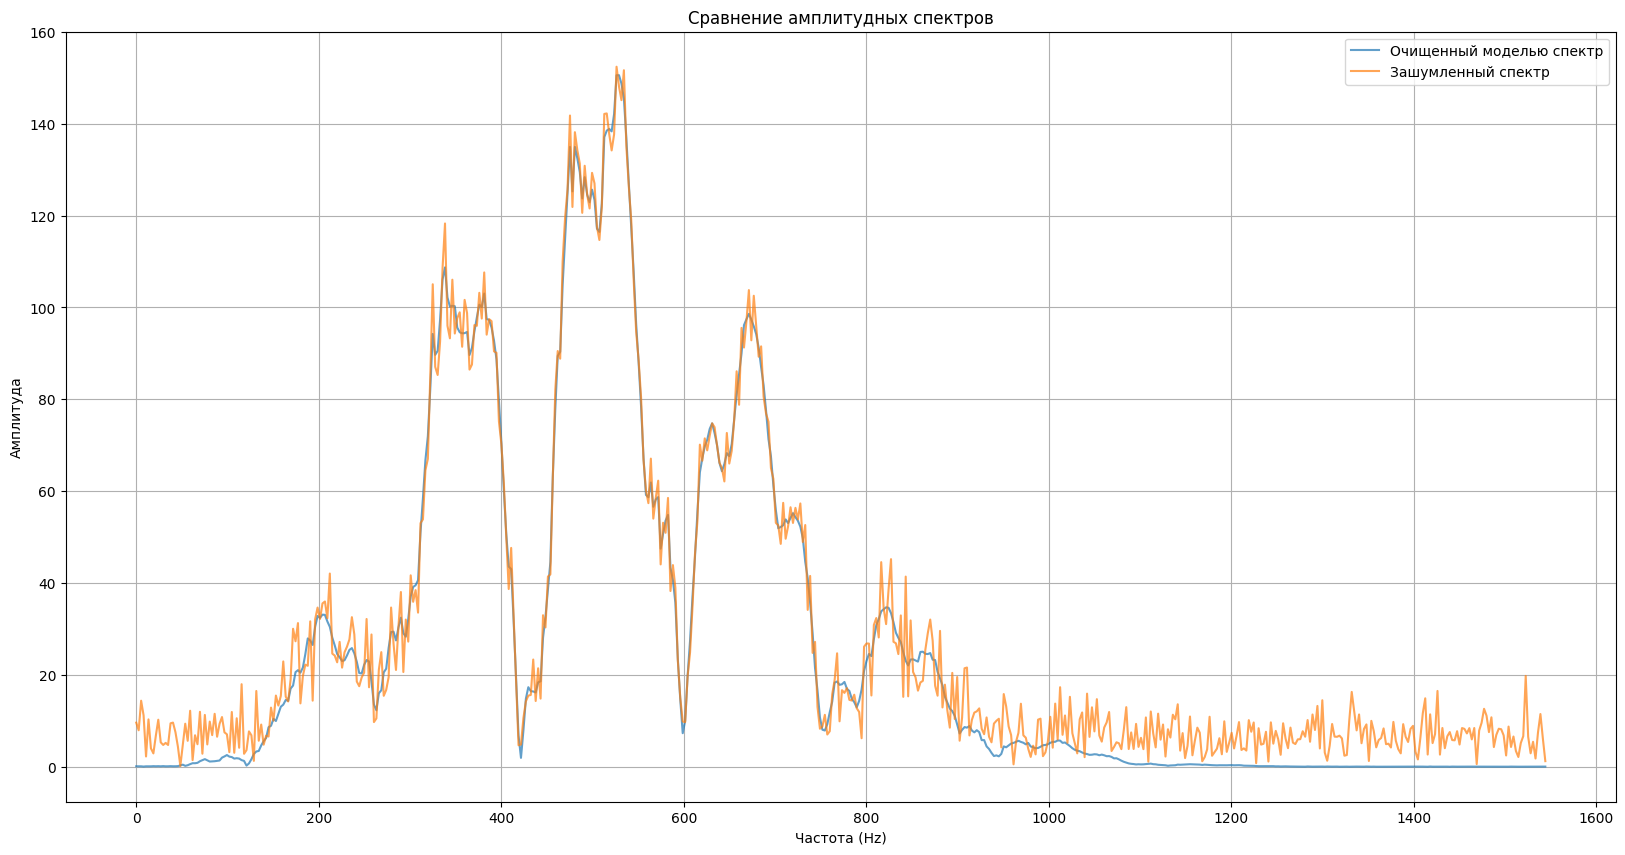

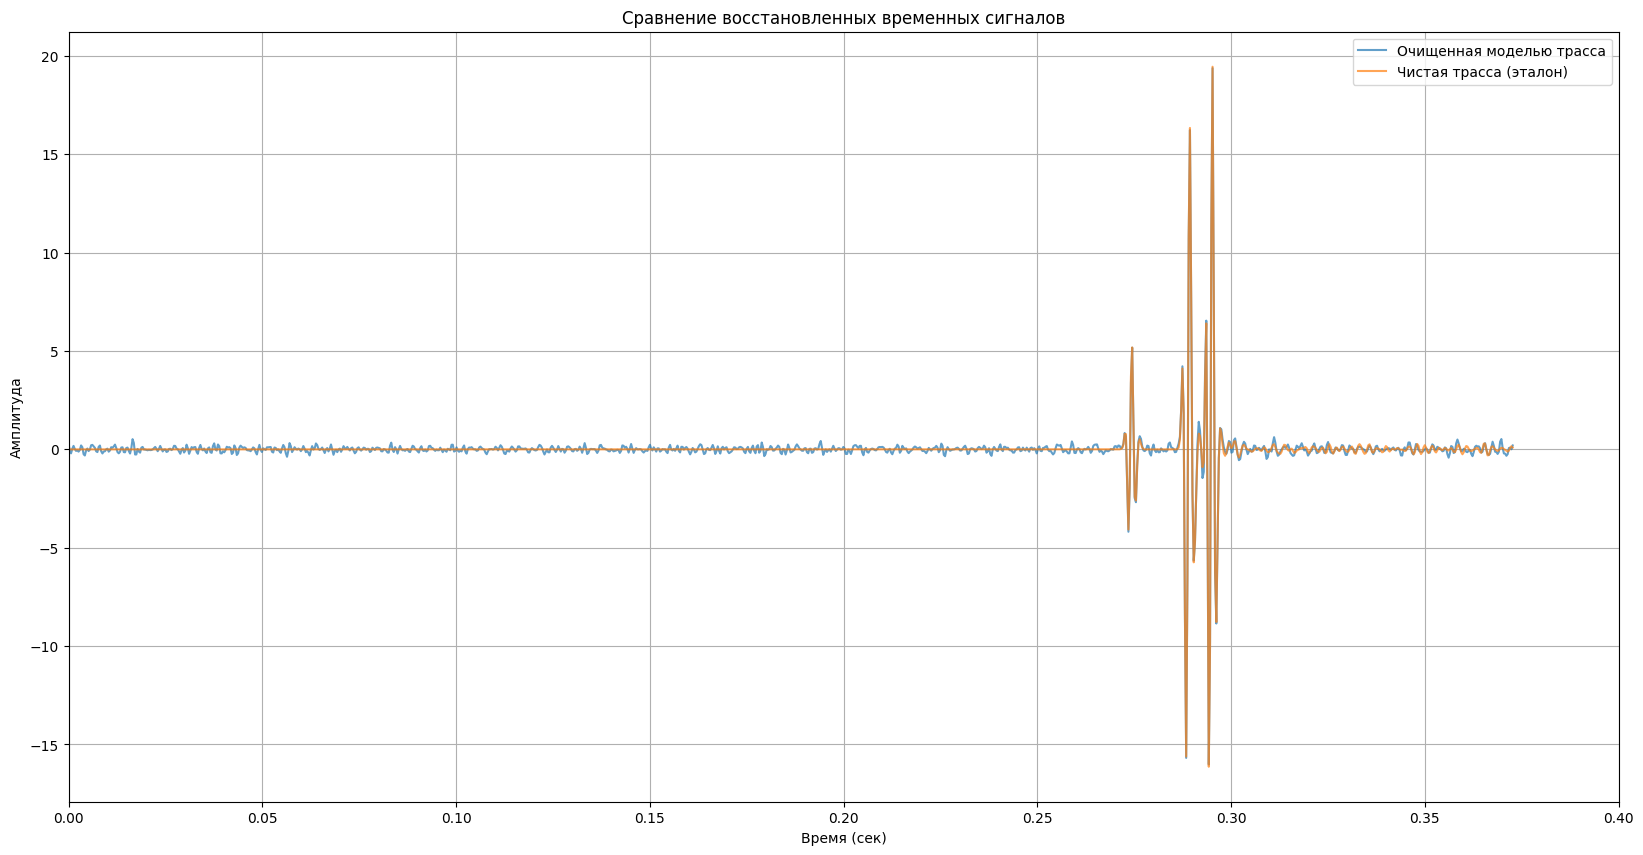

In [1]:
#!/usr/bin/env python3
"""
Эксперимент для тестирования обученной модели XGBoost для удаления шума из амплитудных спектров сейсмограмм.

Порядок действий:
1. Загружаются шумная и чистая сейсмограммы (формат: (1151, 400000)).
2. Из первой трассы вычисляются временной шаг (dt) и частота Найквиста (w_N).
3. Выполняется FFT шумной трассы, затем fftshift; выделяются амплитудный спектр и фаза (положительные 576 точек).
4. Загружается обученная модель XGBoost (best_model.pkl) и применяется для предсказания очищенного спектра.
5. Вычисляется MSE между очищенным и чистым спектрами.
6. На основе предсказанного спектра и исходной фазы восстанавливается временной сигнал (обратное преобразование Фурье).
7. Строятся графики для сравнения спектров и временных сигналов.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error

# Пути к данным и модели
# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()
clean_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_without_noise.npy")
noisy_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_snr=5.npy")
model_path = os.path.join(current_dir, 'models', "best_model.pkl")  # Файл с обученной моделью XGBoost

# Загружаем сейсмограммы (формат: (1151, 400000))
noisy_data = np.load(noisy_path)
clean_data = np.load(clean_path)

# Выбираем первую трассу (индекс 0)
trace_noisy = noisy_data[:, 0]
trace_clean = clean_data[:, 0]

# Вычисляем временной шаг и частоту Найквиста
dt = noisy_data[-1, 0] / 1151
w_N = 1 / (2 * dt)

# Выполняем FFT шумной трассы
Fsig_noisy = np.fft.fft(trace_noisy)
Fsig_noisy_shifted = np.fft.fftshift(Fsig_noisy)
AFsig_noisy = np.abs(Fsig_noisy_shifted)
middle_index = len(AFsig_noisy) // 2
# Выбираем положительные частоты (576 значений)
AFsig_noisy_filtered = AFsig_noisy[middle_index:]
phase_noisy_filtered = np.angle(Fsig_noisy_shifted)[middle_index:]

# Для сравнения вычисляем спектр чистой трассы
Fsig_clean = np.fft.fft(trace_clean)
Fsig_clean_shifted = np.fft.fftshift(Fsig_clean)
AFsig_clean = np.abs(Fsig_clean_shifted)
AFsig_clean_filtered = AFsig_clean[middle_index:]
phase_clean_filtered = np.angle(Fsig_clean_shifted)[middle_index:]

# Формируем вектор частот для графиков
freqs = np.linspace(0, w_N, len(AFsig_noisy_filtered))

# Загружаем обученную модель XGBoost
with open(model_path, "rb") as f:
    model = pickle.load(f)

# Применяем модель для предсказания очищенного спектра
# Модель XGBoost ожидает входные данные в виде двумерного массива (num_samples, num_features)
# Здесь наш вектор спектра имеет длину 576, поэтому преобразуем его в массив shape (1, 576)
denoised_amp = model.predict(AFsig_noisy_filtered.reshape(1, -1))[0]

# Вычисляем MSE между предсказанным спектром и эталонным спектром чистой трассы
mse = mean_squared_error(AFsig_clean_filtered, denoised_amp)
print(f"MSE между спектром, очищенным моделью, и чистым спектром: {mse:.6f}")

# Визуализация амплитудных спектров
# plt.figure(figsize=(20, 10))
# plt.plot(freqs, denoised_amp, label="Очищенный моделью спектр", alpha=0.7)
# plt.plot(freqs, AFsig_clean_filtered, label="Чистый спектр (эталон)", alpha=0.7)
# plt.xlabel("Частота (Hz)")
# plt.ylabel("Амплитуда")
# plt.title("Сравнение амплитудных спектров")
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(20, 10))
plt.plot(freqs, denoised_amp, label="Очищенный моделью спектр", alpha=0.7)
plt.plot(freqs, AFsig_noisy_filtered, label="Зашумленный спектр", alpha=0.7)
plt.xlabel("Частота (Hz)")
plt.ylabel("Амплитуда")
plt.title("Сравнение амплитудных спектров")
plt.legend()
plt.grid(True)
plt.show()

# Визуализация отдельных спектров
# plt.figure(figsize=(10, 6))
# plt.plot(freqs, AFsig_noisy_filtered, color='red')
# plt.title("Зашумлённый спектр")
# plt.xlabel("Частота (Hz)")
# plt.ylabel("Амплитуда")
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(freqs, denoised_amp, color='green')
# plt.title("Очищенный моделью спектр")
# plt.xlabel("Частота (Hz)")
# plt.ylabel("Амплитуда")
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(freqs, AFsig_clean_filtered, color='blue')
# plt.title("Чистый спектр (эталон)")
# plt.xlabel("Частота (Hz)")
# plt.ylabel("Амплитуда")
# plt.grid(True)
# plt.show()

# Восстановление временного сигнала
# Сборка комплексного спектра: используем очищенную амплитуду и оригинальную фазу для положительных частот;
# для отрицательных восстанавливаем конъюгированную симметрию.
new_Fsig_shifted = np.zeros_like(Fsig_noisy_shifted, dtype=complex)
new_Fsig_shifted[middle_index:] = denoised_amp * np.exp(1j * phase_noisy_filtered)
new_Fsig_shifted[:middle_index] = np.conjugate(new_Fsig_shifted[-1:middle_index:-1])
new_Fsig = np.fft.ifftshift(new_Fsig_shifted)
sig_denoised = np.fft.ifft(new_Fsig).real

# Для сравнения, получаем временные сигналы непосредственно из FFT
noisy_recovered = np.fft.ifft(np.fft.ifftshift(Fsig_noisy_shifted)).real
clean_recovered = np.fft.ifft(np.fft.ifftshift(Fsig_clean_shifted)).real

# Формируем вектор времени (число отсчётов = 1151)
t = np.linspace(0, 1151 * dt, 1151)

# Визуальное сравнение восстановленных временных сигналов
plt.figure(figsize=(20, 10))
plt.plot(t, sig_denoised, label="Очищенная моделью трасса", alpha=0.7)
plt.plot(t, clean_recovered, label="Чистая трасса (эталон)", alpha=0.7)
plt.xlim(0, 0.4)  # Ограничиваем ось времени, например, первые 0.4 сек
plt.xlabel("Время (сек)")
plt.ylabel("Амплитуда")
plt.title("Сравнение восстановленных временных сигналов")
plt.legend()
plt.grid(True)
plt.show()


MSE между спектром, очищенным моделью, и чистым спектром: 2.424736


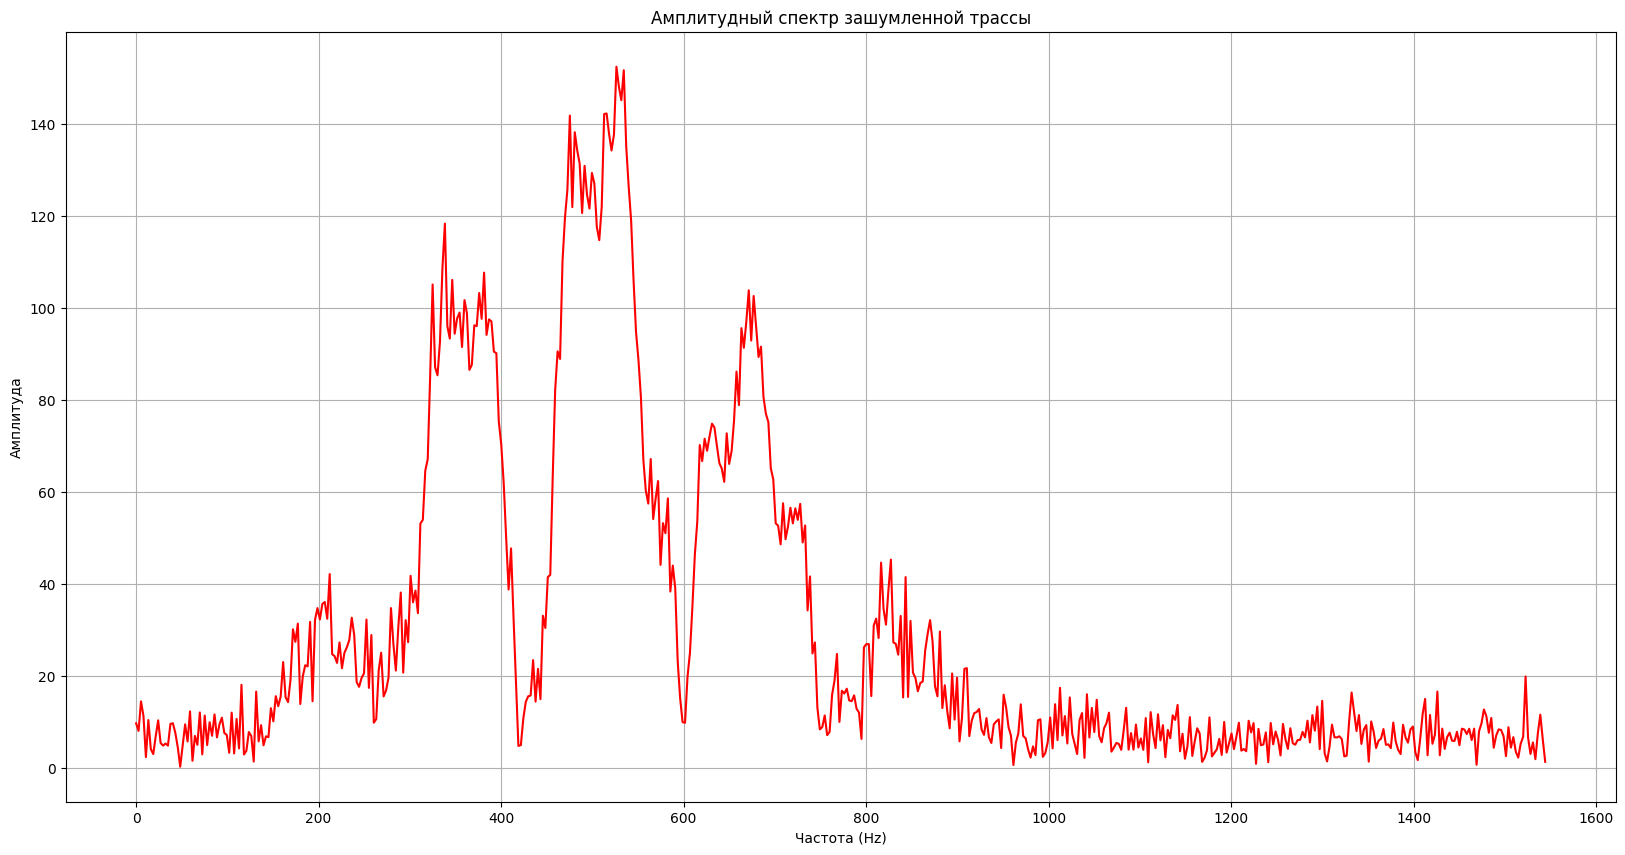

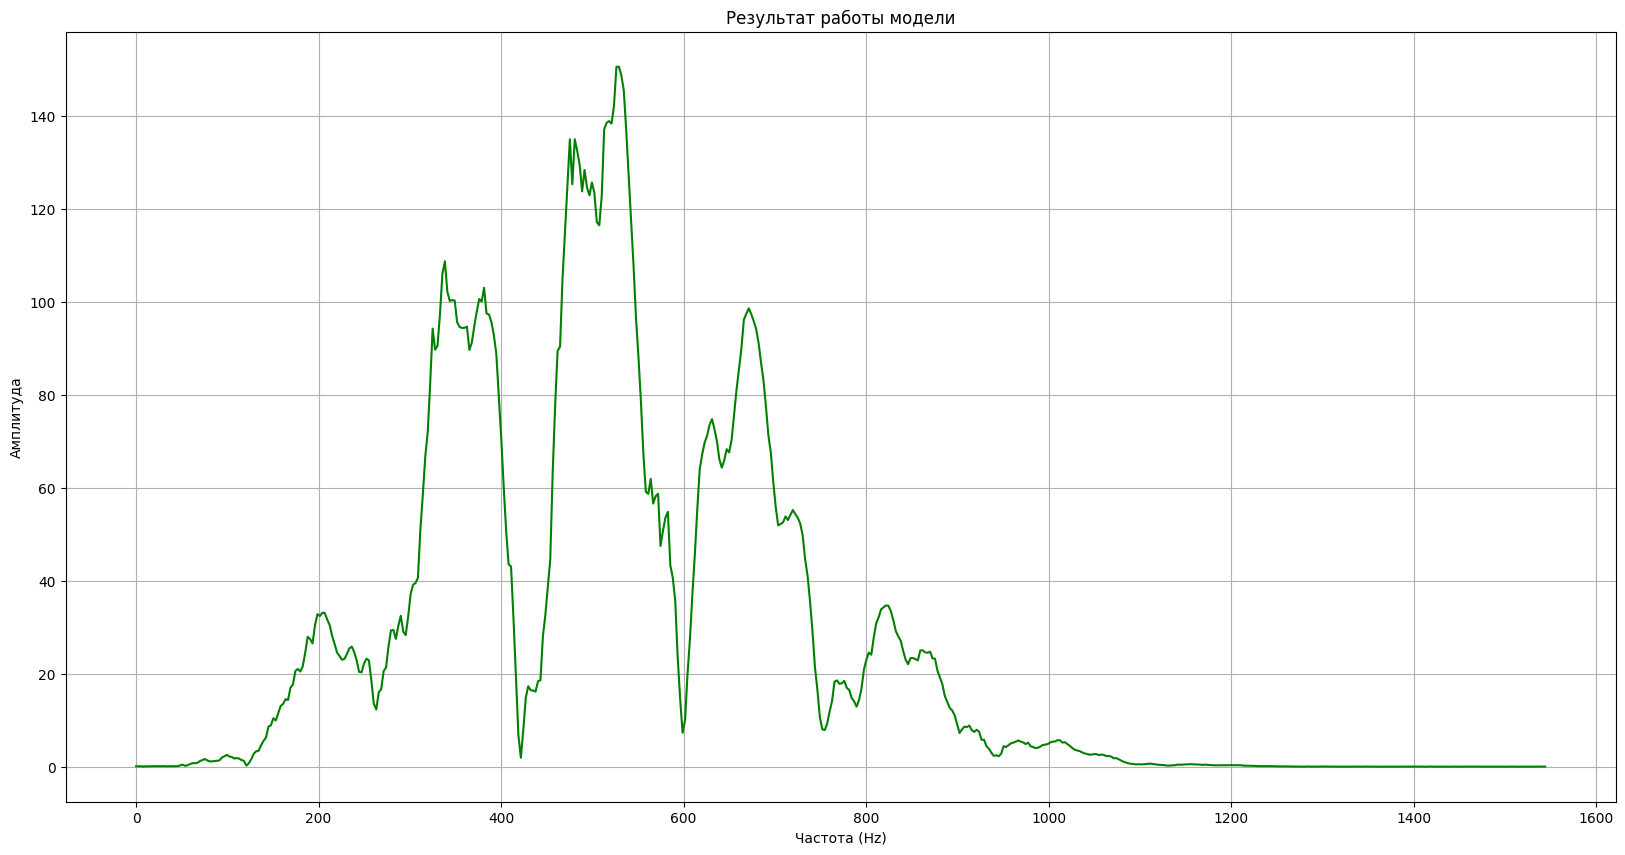

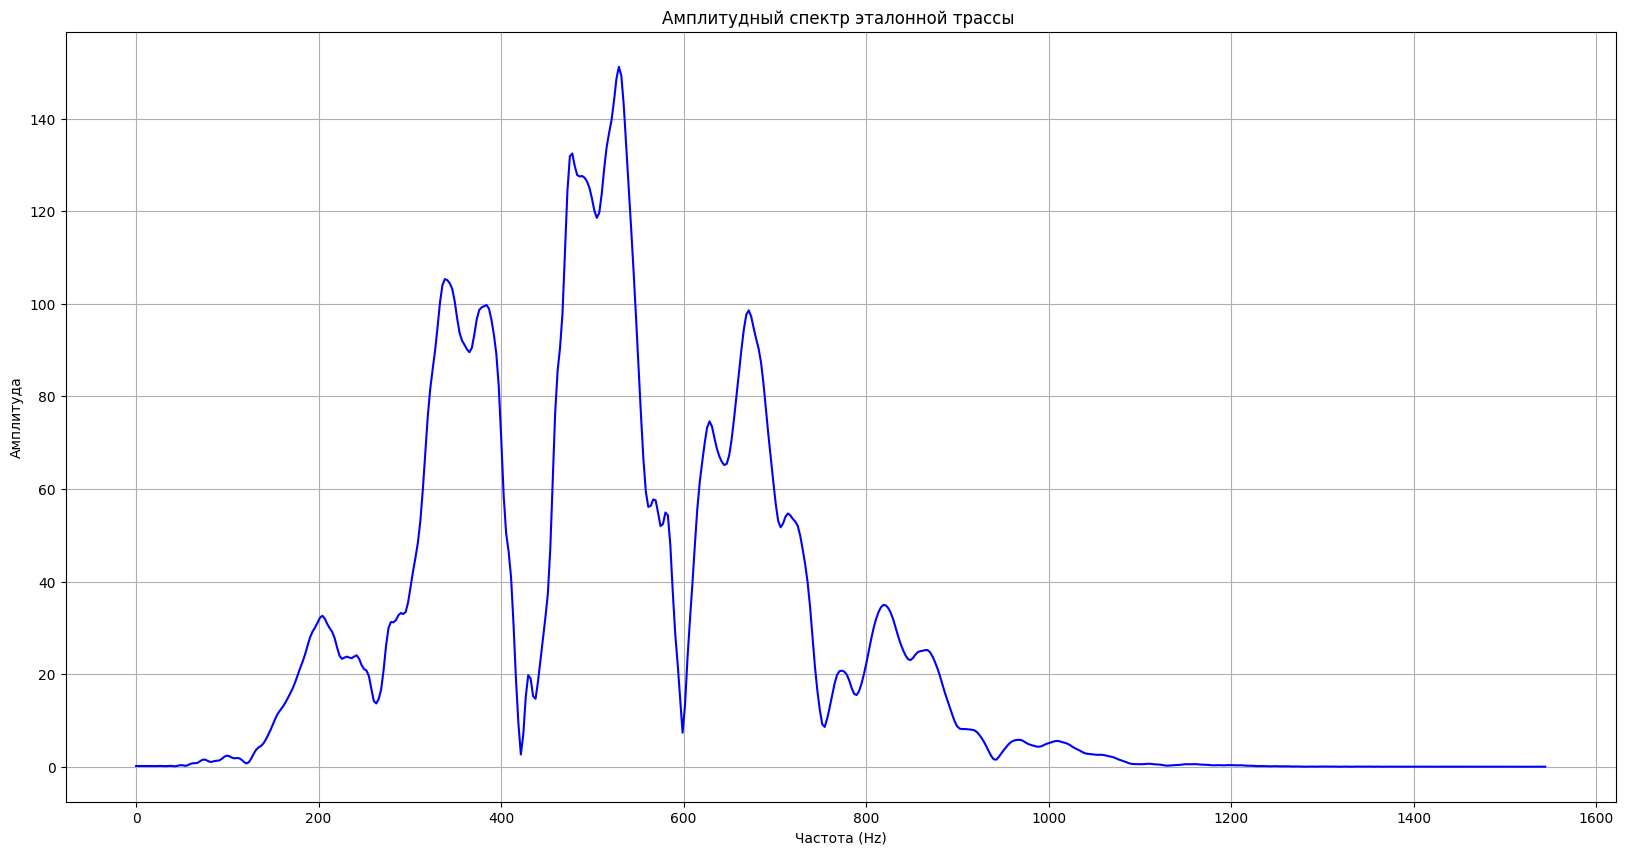

C:\Users\Daniil\AppData\Local\Temp\ipykernel_7228\1934057997.py:145: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


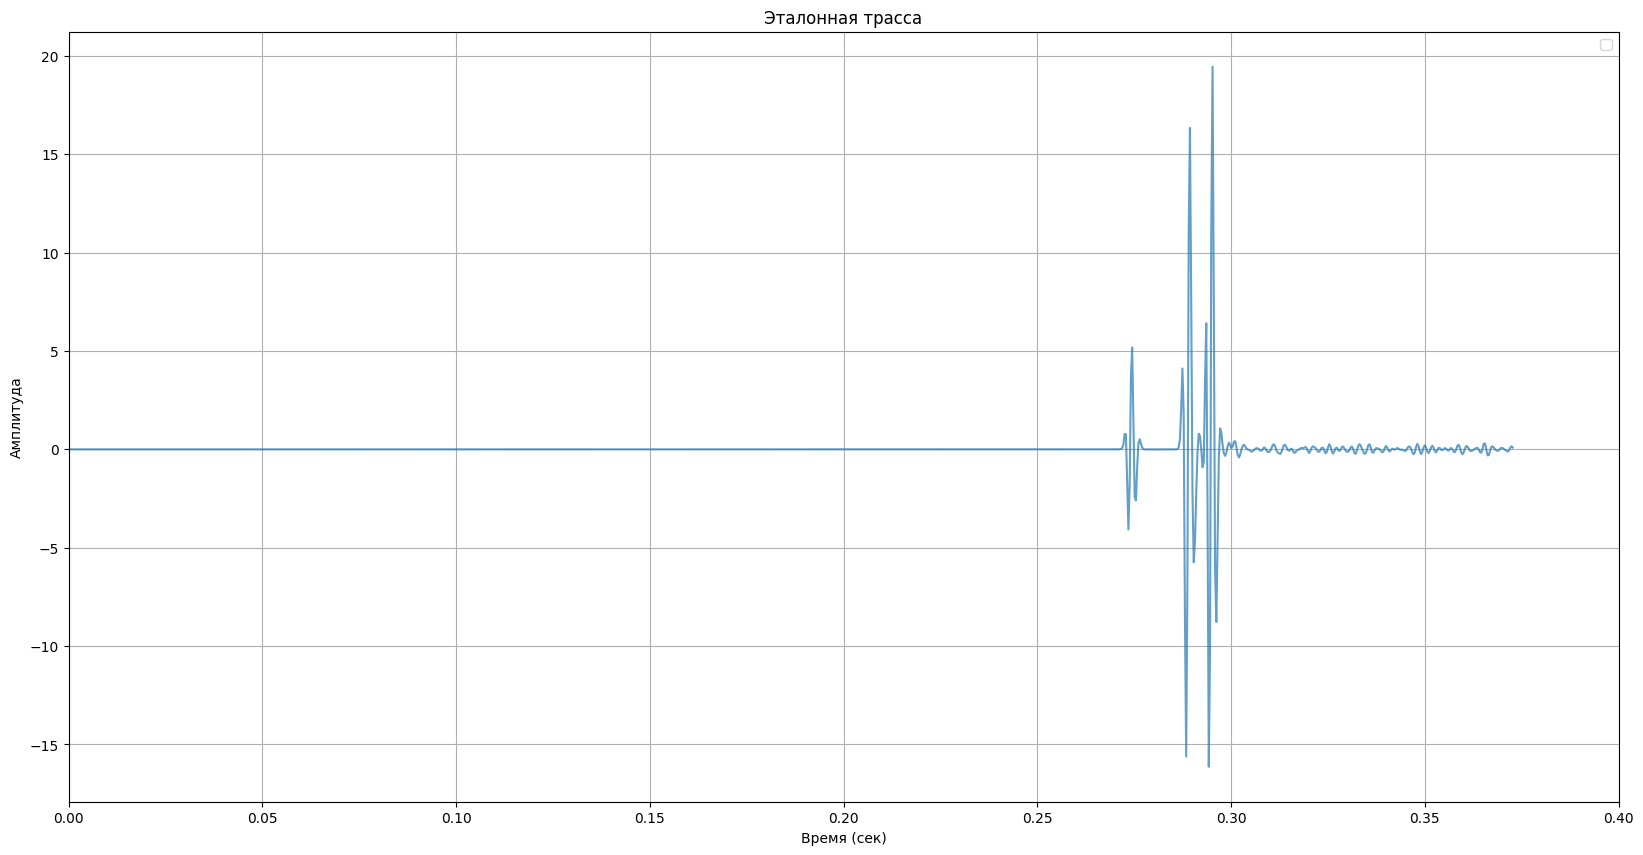

C:\Users\Daniil\AppData\Local\Temp\ipykernel_7228\1934057997.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


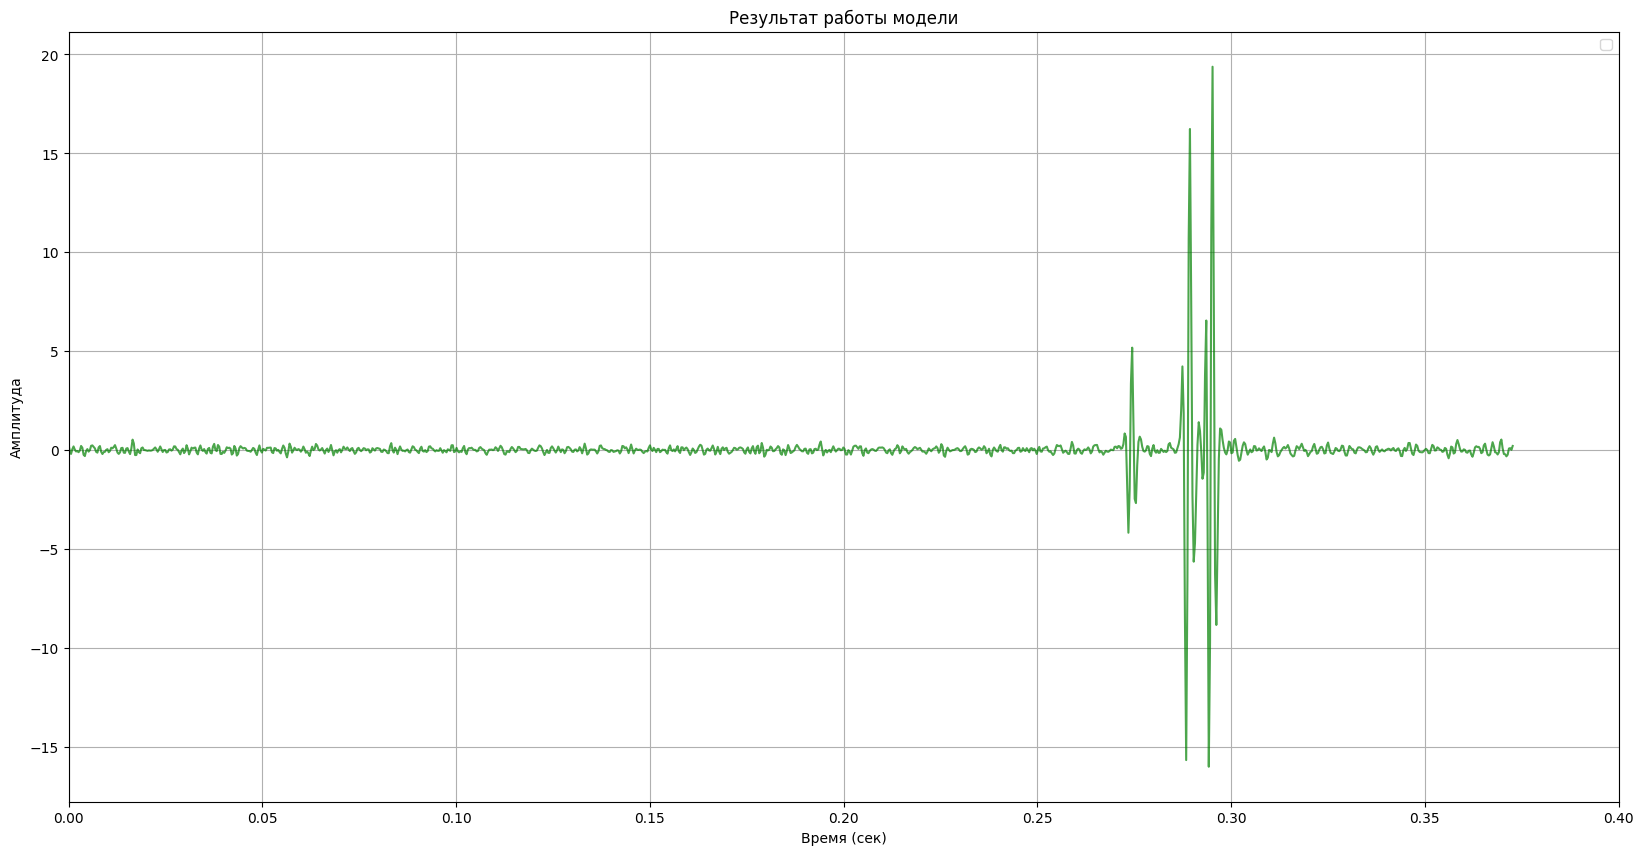

C:\Users\Daniil\AppData\Local\Temp\ipykernel_7228\1934057997.py:169: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


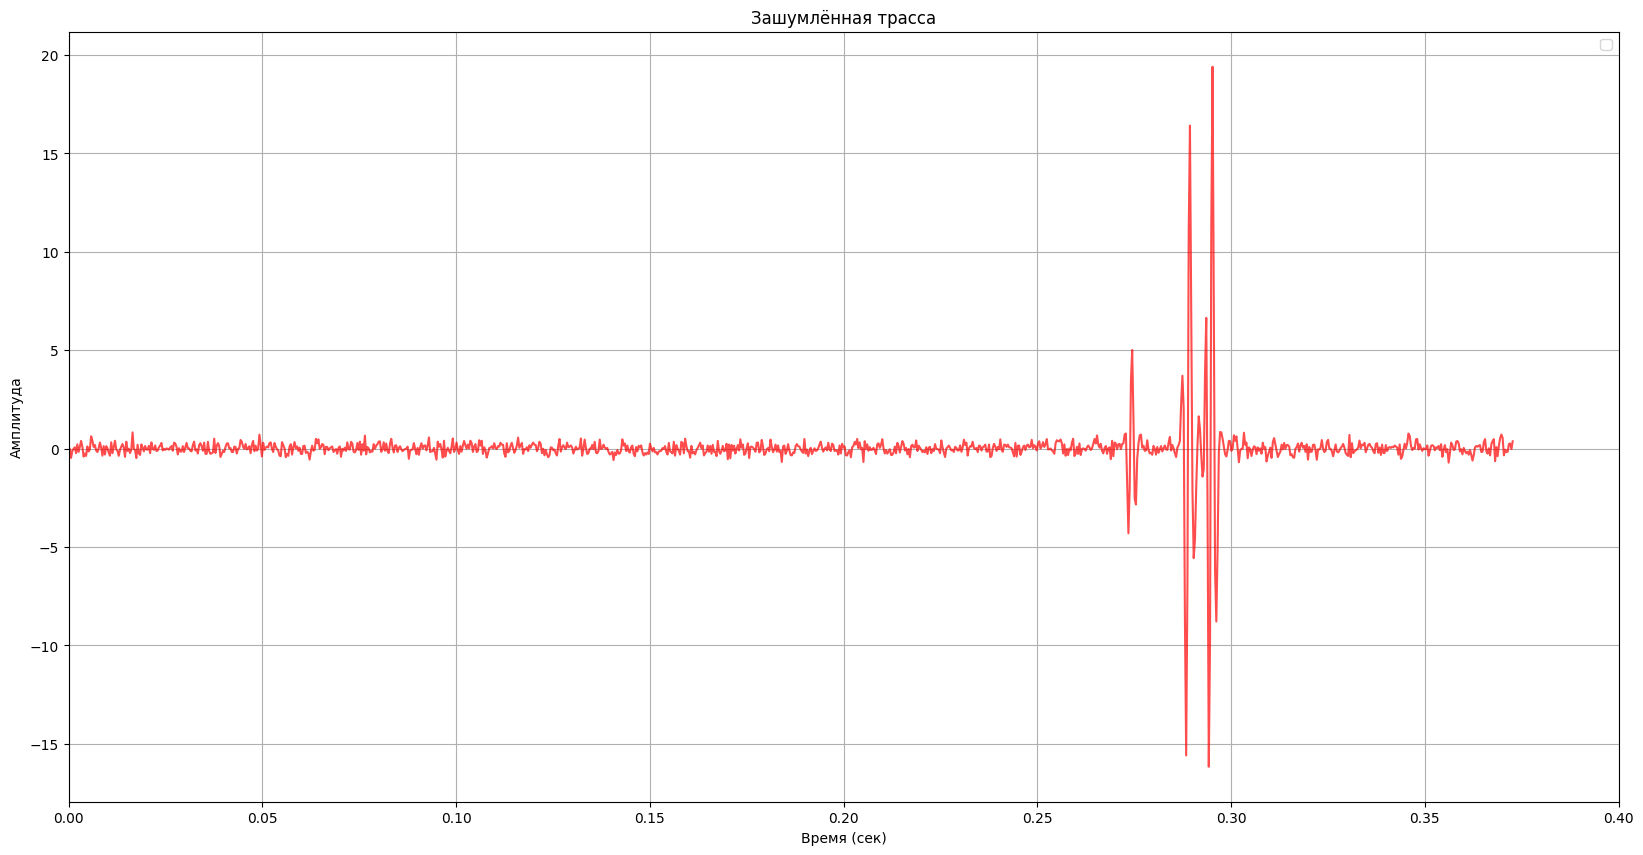

In [1]:
_#!/usr/bin/env python3
"""
Скрипт для тестирования обученной модели XGBoost для удаления шума из амплитудных спектров сейсмограмм.

Порядок действий:
1. Загружаются шумная и чистая сейсмограммы из .npy файлов.
2. Извлекается первая трасса (индекс 0) и вычисляются временной шаг (dt) и частота Найквиста (w_N).
3. Выполняется FFT выбранной трассы, сдвиг спектра (fftshift), вычисление амплитудного спектра и фазы;
   выделяются только положительные частоты (576 значений).
4. Загружается обученная модель XGBoost (best_model.pkl) и применяется для предсказания очищенного спектра.
5. Вычисляется MSE между очищенным и чистым спектрами.
6. Восстанавливается временной сигнал:
   - Сборка комплексного спектра с использованием предсказанной амплитуды и сохранённой фазы,
   - Обратный сдвиг (ifftshift) и обратное преобразование Фурье (ifft).
7. Строятся графики для сравнения амплитудных спектров и восстановленных временных сигналов.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error

# -------------------------------
# Задание путей к данным и модели
# -------------------------------
current_dir = os.getcwd()
clean_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_without_noise.npy")
noisy_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_snr=5.npy")
model_path = os.path.join(current_dir, 'models', "best_model.pkl")  # Файл с обученной моделью XGBoost


# -------------------------------
# Загрузка сейсмограмм и выбор первой трассы
# -------------------------------
noisy_data = np.load(noisy_path)
clean_data = np.load(clean_path)
trace_noisy = noisy_data[:, 0]
trace_clean = clean_data[:, 0]

# -------------------------------
# Вычисление временных параметров
# -------------------------------
dt = noisy_data[-1, 0] / 1151  # Вычисляем временной шаг
w_N = 1 / (2 * dt)            # Частота Найквиста

# -------------------------------
# Прямое преобразование Фурье для шумной трассы
# -------------------------------
Fsig_noisy = np.fft.fft(trace_noisy)
Fsig_noisy_shifted = np.fft.fftshift(Fsig_noisy)
AFsig_noisy = np.abs(Fsig_noisy_shifted)
middle_index = len(AFsig_noisy) // 2
AFsig_noisy_filtered = AFsig_noisy[middle_index:]
phase_noisy_filtered = np.angle(Fsig_noisy_shifted)[middle_index:]

# Аналогичное преобразование для чистой трассы (эталон)
Fsig_clean = np.fft.fft(trace_clean)
Fsig_clean_shifted = np.fft.fftshift(Fsig_clean)
AFsig_clean = np.abs(Fsig_clean_shifted)
AFsig_clean_filtered = AFsig_clean[middle_index:]
phase_clean_filtered = np.angle(Fsig_clean_shifted)[middle_index:]

# Вектор частот для построения графиков
freqs = np.linspace(0, w_N, len(AFsig_noisy_filtered))

# -------------------------------
# Загрузка обученной модели XGBoost и предсказание очищенного спектра
# -------------------------------
with open(model_path, "rb") as f:
    xgb_model = pickle.load(f)

# Модель XGBoost ожидает вход в виде двумерного массива
denoised_amp = xgb_model.predict(AFsig_noisy_filtered.reshape(1, -1))[0]

# Вычисление MSE между предсказанным спектром и спектром чистой трассы
mse = mean_squared_error(AFsig_clean_filtered, denoised_amp)
print(f"MSE между спектром, очищенным моделью, и чистым спектром: {mse:.6f}")

# -------------------------------
# Визуальное сравнение амплитудных спектров
# -------------------------------
# plt.figure(figsize=(20, 10))
# plt.plot(freqs, denoised_amp, label="Очищенный моделью спектр", alpha=0.7)
# plt.plot(freqs, AFsig_clean_filtered, label="Чистый спектр (эталон)", alpha=0.7)
# plt.xlabel("Частота (Hz)")
# plt.ylabel("Амплитуда")
# plt.title("Сравнение амплитудных спектров")
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(20, 10))
plt.plot(freqs, AFsig_noisy_filtered, color='red')
plt.title("Амплитудный спектр зашумленной трассы")
plt.xlabel("Частота (Hz)")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(freqs, denoised_amp, color='green')
plt.title("Результат работы модели")
plt.xlabel("Частота (Hz)")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(freqs, AFsig_clean_filtered, color='blue')
plt.title("Амплитудный спектр эталонной трассы ")
plt.xlabel("Частота (Hz)")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.show()

# -------------------------------
# Восстановление временного сигнала
# -------------------------------
new_Fsig_shifted = np.zeros_like(Fsig_noisy_shifted, dtype=complex)
new_Fsig_shifted[middle_index:] = denoised_amp * np.exp(1j * phase_noisy_filtered)
new_Fsig_shifted[:middle_index] = np.conjugate(new_Fsig_shifted[-1:middle_index:-1])
new_Fsig = np.fft.ifftshift(new_Fsig_shifted)
sig_denoised = np.fft.ifft(new_Fsig).real

# Получение временных сигналов непосредственно из FFT для сравнения
noisy_recovered = np.fft.ifft(np.fft.ifftshift(Fsig_noisy_shifted)).real
clean_recovered = np.fft.ifft(np.fft.ifftshift(Fsig_clean_shifted)).real

# Вектор времени (число отсчётов = 1151)
t = np.linspace(0, 1151 * dt, 1151)

# -------------------------------
# Визуальное сравнение восстановленных временных сигналов
# -------------------------------
# Зашумлённая трасса
# Визуальное сравнение восстановленных временных сигналов
plt.figure(figsize=(20, 10))
# plt.plot(t, sig_denoised, label="Очищенная моделью трасса", alpha=0.7)
plt.plot(t, clean_recovered, alpha=0.7)
plt.xlim(0, 0.4)  # Ограничиваем ось времени, например, первые 0.4 сек
plt.xlabel("Время (сек)")
plt.ylabel("Амплитуда")
plt.title("Эталонная трасса")
plt.legend()
plt.grid(True)
plt.show()

# Визуальное сравнение восстановленных временных сигналов
plt.figure(figsize=(20, 10))
plt.plot(t, sig_denoised, alpha=0.7, color='green')
# plt.plot(t, clean_recovered, label="Чистая трасса (эталон)", alpha=0.7)
plt.xlim(0, 0.4)  # Ограничиваем ось времени, например, первые 0.4 сек
plt.xlabel("Время (сек)")
plt.ylabel("Амплитуда")
plt.title("Результат работы модели")
plt.legend()
plt.grid(True)
plt.show()

# Визуальное сравнение восстановленных временных сигналов
plt.figure(figsize=(20, 10))
plt.plot(t, trace_noisy, alpha=0.7, color='red')
# plt.plot(t, clean_recovered, label="Чистая трасса (эталон)", alpha=0.7)
plt.xlim(0, 0.4)  # Ограничиваем ось времени, например, первые 0.4 сек
plt.xlabel("Время (сек)")
plt.ylabel("Амплитуда")
plt.title("Зашумлённая трасса")
plt.legend()
plt.grid(True)
plt.show()


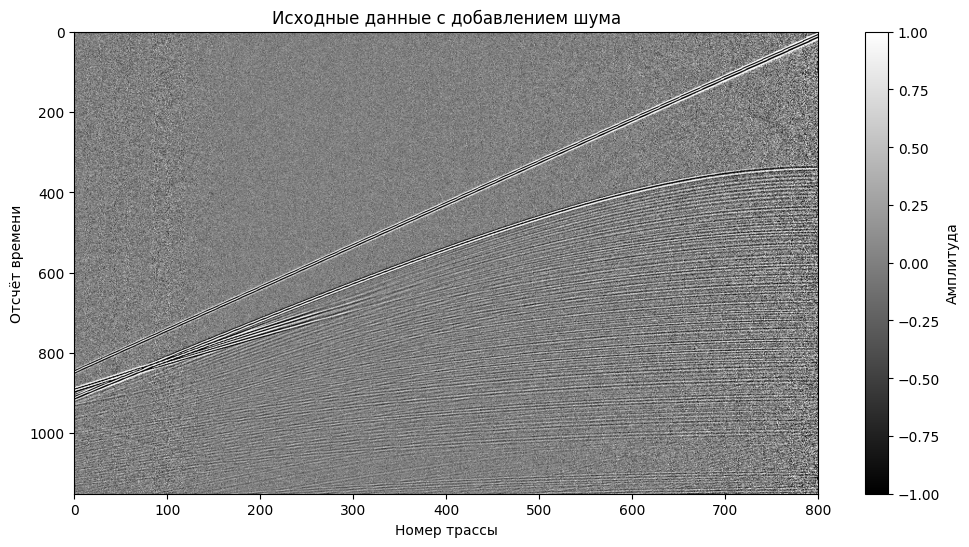

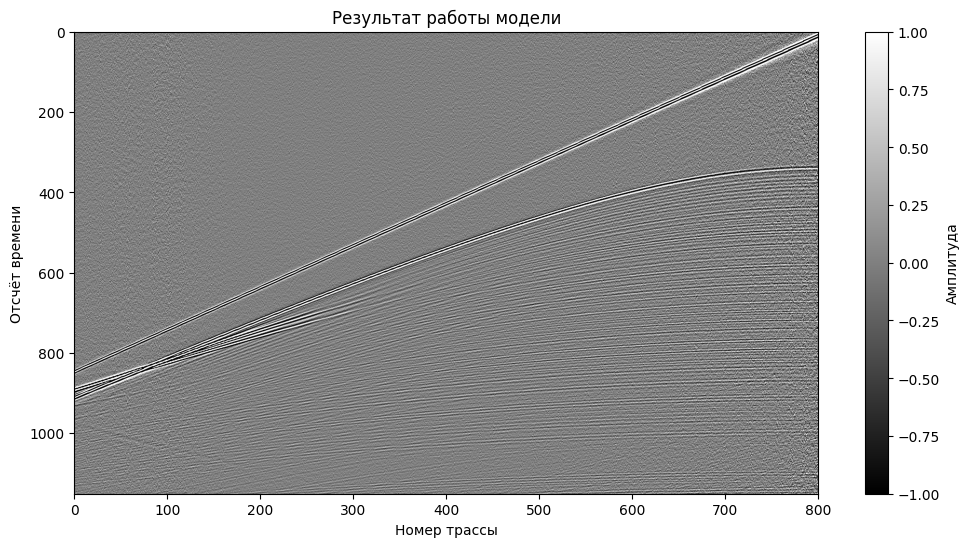

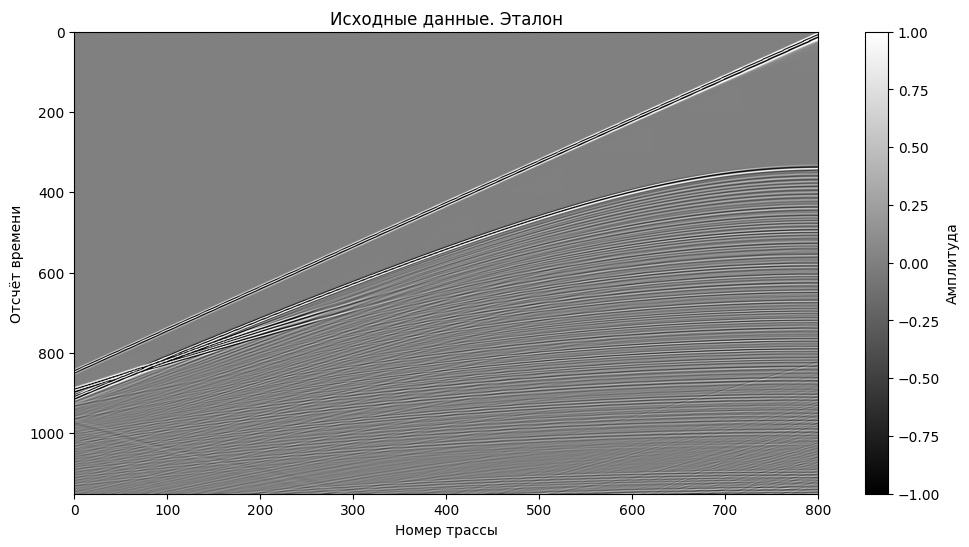

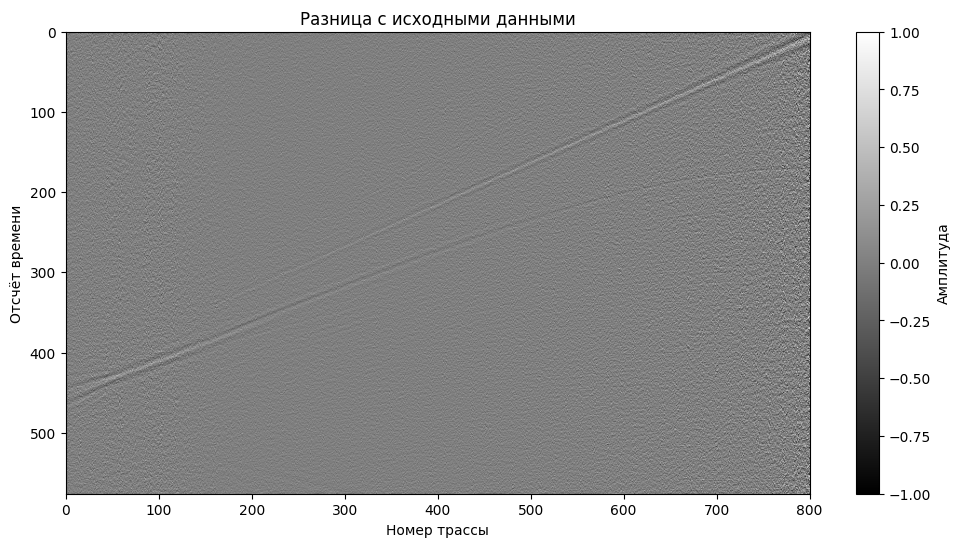

Массивы сохранены в файлы: 'restored_seismogram.npy', 'clean_800.npy', 'noisy_800.npy'


In [1]:
#!/usr/bin/env python3
"""
Скрипт для обработки первых 800 трасс зашумленной сейсмограммы с применением обученной модели XGBoost для очистки спектров.
Порядок действий:
1. Извлекаем первые 800 трасс из спектральных представлений (уже вычисленных и сохранённых в .npy файлах).
2. Для каждой трассы:
   - Вычисляем фазу, используя исходную временную трассу из шумной сейсмограммы.
   - Передаём вектор амплитуд (положительные частоты, 576 значений) в обученную модель XGBoost для предсказания очищённого спектра.
   - Собираем новый комплексный спектр с использованием предсказанной амплитуды и исходной фазы, заполняем отрицательные частоты через конъюгированную симметрию.
   - Выполняем обратный сдвиг (ifftshift) и обратное преобразование Фурье (ifft) для восстановления временного сигнала.
3. Собираем восстановленные трассы в новую сейсмограмму (800 трасс).
4. Визуализируем:
   - Оригинальную зашумленную сейсмограмму (800 трасс) из исходных временных сигналов.
   - Восстановленную сейсмограмму (800 трасс, обработанные моделью).
   - Оригинальную чистую сейсмограмму (800 трасс).
5. Сохраняем массивы restored_seismogram, clean_800 и noisy_800 в файлы .npy.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

# -------------------------------
# Задание путей к данным и модели
# -------------------------------
current_dir = os.getcwd()
clean_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_without_noise.npy")
noisy_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_snr=5.npy")
clean_spec_path = os.path.join(current_dir, "spectres", "clean_spectra.npy")
noisy_spec_path = os.path.join(current_dir, "spectres", "noisy_spectra.npy")
# Пути к исходным сейсмограммам (для восстановления фазовой информации)
clean_data_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_without_noise.npy")
noisy_data_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_snr=5.npy")
# Файл с обученной моделью XGBoost
# model_path = os.path.join(current_dir, "best_model.pkl")
model_path = os.path.join(current_dir, 'models', "best_model.pkl")  # Файл с обученной моделью XGBoost

# -------------------------------
# Загрузка спектров и исходных сейсмограмм
# -------------------------------
# Спектры сохранены в виде (num_traces, 576)
noisy_spectra = np.load(noisy_spec_path)
clean_spectra = np.load(clean_spec_path)
# Выбираем первые 800 трасс и транспонируем (получаем форму (576, 800))
noisy_800 = noisy_spectra[:800, :].T
clean_800 = clean_spectra[:800, :].T

# Загрузка исходных сейсмограмм (формат: (1151, 400000))
noisy_data = np.load(noisy_data_path)
clean_data = np.load(clean_data_path)
# Извлекаем первые 800 трасс (временные сигналы)
noisy_full_800 = noisy_data[:, :800]
clean_full_800 = clean_data[:, :800]

# -------------------------------
# Загрузка обученной модели XGBoost
# -------------------------------
with open(model_path, "rb") as f:
    xgb_model = pickle.load(f)

# -------------------------------
# Обработка каждой трассы: очистка спектров и восстановление временных сигналов
# -------------------------------
# Инициализируем массив для восстановления временных сигналов (форма: (1151, 800))
restored_seismogram = np.zeros_like(noisy_full_800)

# Для каждой трассы (каждый столбец в спектральном представлении, размер 576)
num_samples, num_traces = noisy_full_800.shape  # (1151, 800)
for i in range(num_traces):
    # Из сохранённых спектров берем амплитуду (положительные частоты)
    amplitude = noisy_800[:, i]  # форма (576,)
    
    # Для фазовой информации используем исходную временную трассу из шумной сейсмограммы
    trace = noisy_full_800[:, i]
    Fsig = np.fft.fft(trace)
    Fsig_shifted = np.fft.fftshift(Fsig)
    phase = np.angle(Fsig_shifted)
    middle_index = len(Fsig_shifted) // 2  # Ожидается, что положительная часть имеет длину 576
    phase_positive = phase[middle_index:]
    
    # Применяем модель XGBoost: вход должен быть двумерным (1,576)
    denoised_amp = xgb_model.predict(amplitude.reshape(1, -1))[0]
    
    # Сборка нового комплексного спектра:
    new_Fsig_shifted = np.zeros_like(Fsig_shifted, dtype=complex)
    new_Fsig_shifted[middle_index:] = denoised_amp * np.exp(1j * phase_positive)
    new_Fsig_shifted[:middle_index] = np.conjugate(new_Fsig_shifted[-1:middle_index:-1])
    
    # Обратный сдвиг и обратное преобразование Фурье для восстановления временного сигнала
    new_Fsig = np.fft.ifftshift(new_Fsig_shifted)
    restored_trace = np.fft.ifft(new_Fsig).real
    restored_seismogram[:, i] = restored_trace

# -------------------------------
# Визуализация результатов
# -------------------------------
# 1. Оригинальная зашумленная сейсмограмма (800 трасс)
plt.figure(figsize=(12, 6))
plt.imshow(noisy_full_800, aspect='auto', cmap='gray', extent=[0, 800, noisy_full_800.shape[0], 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Исходные данные с добавлением шума")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# 2. Новая сейсмограмма (800 трасс, восстановленные через модель)
plt.figure(figsize=(12, 6))
plt.imshow(restored_seismogram, aspect='auto', cmap='gray', extent=[0, 800, restored_seismogram.shape[0], 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Результат работы модели")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# 3. Оригинальная чистая сейсмограмма (800 трасс)
plt.figure(figsize=(12, 6))
plt.imshow(clean_full_800, aspect='auto', cmap='gray', extent=[0, 800, clean_full_800.shape[0], 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Исходные данные. Эталон")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# -------------------------------
# Визуализация оригинальной чистой сейсмограммы (первые 800 трасс)
# -------------------------------
plt.figure(figsize=(12, 6))
plt.imshow(clean_full_800-restored_seismogram, aspect='auto', cmap='gray', extent=[0, 800, noisy_800.shape[0], 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Разница с исходными данными")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# 4. Сохранение массивов в файлы .npy
np.save('restored_seismogram.npy', restored_seismogram)
np.save('clean_800.npy', clean_full_800)
np.save('noisy_800.npy', noisy_full_800)
print("Массивы сохранены в файлы: 'restored_seismogram.npy', 'clean_800.npy', 'noisy_800.npy'")


In [3]:
print(f'MSE={np.mean((clean_full_800 - restored_seismogram) ** 2)}')

MSE=0.025385381653904915


In [ ]:
#!/usr/bin/env python3
"""
Скрипт для обработки первых 800 трасс зашумленной сейсмограммы с применением обученной модели XGBoost для очистки спектров.
Порядок действий:
1. Извлекаем первые 800 трасс исходной зашумлённой сейсмограммы.
2. Для каждой трассы:
   - Выполняем прямое преобразование Фурье (rfft) для получения спектра.
   - Выделяем амплитуду и фазу спектра.
   - Передаём вектор амплитуд (576 значений) в обученную модель XGBoost для получения предсказания очищенного спектра.
   - Формируем новый спектр, комбинируя предсказанную амплитуду и исходную фазу.
   - Выполняем обратное преобразование Фурье (irfft) для восстановления временного сигнала.
3. Собираем восстановленные трассы в новую сейсмограмму.
4. Визуализируем зашумлённую, восстановленную и чистую сейсмограммы.
5. Сохраняем полученные массивы в файлы .npy.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

# -------------------------------
# Функции преобразования Фурье
# -------------------------------
def seis_fft(seismogram, dt):
    """
    Выполняет прямое преобразование Фурье (rfft) для каждой трассы сейсмограммы.
    
    :param seismogram: numpy массив размером (num_traces, num_samples)
    :param dt: дискретизация во времени (сек)
    :return: частоты (Hz) и комплексное спектральное представление, размерность (num_traces, num_freq_bins)
    """
    num_traces, num_samples = seismogram.shape
    sampling_rate = 1 / dt  # Гц
    freqs = np.fft.rfftfreq(num_samples, d=1/sampling_rate)
    spectrum = np.fft.rfft(seismogram, axis=1)
    return freqs, spectrum

def seis_ifft(spectrum, dt, num_samples):
    """
    Восстанавливает временной сигнал по спектру с помощью обратного преобразования Фурье (irfft).
    
    :param spectrum: спектральное представление (num_traces, num_freq_bins)
    :param dt: дискретизация во времени (сек)
    :param num_samples: число отсчётов временного сигнала
    :return: восстановленный сигнал в временной области (num_traces, num_samples)
    """
    time_domain_signal = np.fft.irfft(spectrum, axis=1)
    # Если длина восстановленного сигнала меньше исходной, дополняем нулями
    if time_domain_signal.shape[1] < num_samples:
        time_domain_signal = np.pad(time_domain_signal,
                                    ((0, 0), (0, num_samples - time_domain_signal.shape[1])),
                                    mode='constant')
    return time_domain_signal

# -------------------------------
# Параметры и пути к данным
# -------------------------------
dt = 0.004  # дискретизация во времени в секундах, установите под ваши данные

current_dir = os.getcwd()
# Пути к сейсмограммам (формат: (num_samples, total_traces))
clean_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_without_noise.npy")
noisy_path = os.path.join(current_dir, "data", "Anisotropic_FD_Model_Shots_part1_snr=5.npy")
# Пути к исходным данным используются для восстановления фазовой информации
clean_data_path = clean_path
noisy_data_path = noisy_path
# Путь к обученной модели XGBoost
model_path = os.path.join(current_dir, 'models', "best_model.pkl")

# -------------------------------
# Загрузка сейсмограмм и подготовка данных
# -------------------------------
# Загружаем сейсмограммы (изначальный формат: (num_samples, total_traces))
noisy_data = np.load(noisy_data_path)
clean_data = np.load(clean_data_path)
# Извлекаем первые 800 трасс; транспонируем, чтобы каждая трасса была представлена строкой (800, num_samples)
# noisy_full_800 = noisy_data[:, :800]
# clean_full_800 = clean_data[:, :800]
noisy_full_800 = noisy_data[:, :800].T
clean_full_800 = clean_data[:, :800].T

num_traces, num_samples = noisy_full_800.shape  # например, (800, 1151)

# -------------------------------
# Загрузка обученной модели XGBoost
# -------------------------------
with open(model_path, "rb") as f:
    xgb_model = pickle.load(f)

# -------------------------------
# Обработка каждой трассы: очистка спектров и восстановление временных сигналов
# -------------------------------
# Инициализируем массив для восстановления сейсмограммы
restored_seismogram = np.zeros_like(noisy_full_800)

# Для каждой трассы:
for i in range(num_traces):
    # Извлекаем трассу (временной сигнал)
    trace = noisy_full_800[i, :]  # форма (num_samples,)
    
    # Вычисляем спектр трассы с использованием rfft
    freqs, spectrum = seis_fft(trace[np.newaxis, :], dt)  # spectrum имеет форму (1, num_freq_bins)
    
    # Получаем амплитуду и фазу спектра
    amplitude = np.abs(spectrum[0])  # форма (num_freq_bins,), например, 576 значений
    phase = np.angle(spectrum[0])
    
    # Применяем модель XGBoost для очистки спектра: вход должен быть двумерным (1, num_freq_bins)
    denoised_amp = xgb_model.predict(amplitude.reshape(1, -1))[0]
    
    # Формируем новый спектр, используя предсказанную амплитуду и исходную фазу
    new_spectrum = denoised_amp * np.exp(1j * phase)
    
    # Восстанавливаем временной сигнал с использованием обратного преобразования (irfft)
    restored_trace = seis_ifft(new_spectrum[np.newaxis, :], dt, num_samples)[0]
    restored_seismogram[i, :] = restored_trace

# -------------------------------
# Визуализация результатов
# -------------------------------
# 1. Оригинальная зашумленная сейсмограмма (800 трасс)
plt.figure(figsize=(12, 6))
plt.imshow(noisy_full_800.T, aspect='auto', cmap='gray',
           extent=[0, num_traces, num_samples, 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Оригинальная зашумленная сейсмограмма (800 трасс)")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# 2. Восстановленная сейсмограмма (800 трасс, обработанные моделью)
plt.figure(figsize=(12, 6))
plt.imshow(restored_seismogram.T, aspect='auto', cmap='gray',
           extent=[0, num_traces, num_samples, 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Восстановленная сейсмограмма (800 трасс)")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# 3. Оригинальная чистая сейсмограмма (800 трасс)
plt.figure(figsize=(12, 6))
plt.imshow(clean_full_800.T, aspect='auto', cmap='gray',
           extent=[0, num_traces, num_samples, 0], vmin=-1, vmax=1)
plt.colorbar(label='Амплитуда')
plt.title("Оригинальная чистая сейсмограмма (800 трасс)")
plt.xlabel("Номер трассы")
plt.ylabel("Отсчёт времени")
plt.show()

# -------------------------------
# Сохранение результатов
# -------------------------------
np.save('restored_seismogram.npy', restored_seismogram)
np.save('clean_800.npy', clean_full_800)
np.save('noisy_800.npy', noisy_full_800)
print("Массивы сохранены в файлы: 'restored_seismogram.npy', 'clean_800.npy', 'noisy_800.npy'")


In [6]:
print(f'MSE={np.mean((clean_full_800 - restored_seismogram) ** 2)}')

MSE=0.45838832977456606
